In [1]:
import sys
import os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import json
import pathlib

# modify the sys.path to include the source directory
src_dir = pathlib.Path().absolute().parent
sys.path.append(str(src_dir))

from src.enums import DataSplit
from src.utils.visualize import plot_images_and_bboxes
from src.data.bbox import BoundingBoxDetectionDataset
from src.enums import DataSplit
from src.utils.transforms import BBoxResize, BBoxBaseTransform, BBoxCompose, BBoxAnchorEncode
from src.utils.bbox import generate_anchors
from matplotlib.patches import Rectangle
from src.models.object_detection.efficientdet import EfficientDet

In [2]:
a_cen, a_cor = generate_anchors(256, scales=[0.1, 0.175, 0.25, 0.5, 0.35], aspect_ratios=[1, 2, 0.666], feature_map_sizes=[32])

In [3]:
32 * 32 * 5 * 3

15360

In [4]:
a_cen.shape

(15360, 4)

In [5]:
efficient_det = EfficientDet(pretrained_backbone=False, n_classes=1, n_anchors=3, bifpn_layers=3, n_channels=64)

# Count the total number of parameters
total_params = sum(p.numel() for p in efficient_det.parameters())
# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in efficient_det.parameters() if p.requires_grad)

print(f"Total number of parameters: {total_params}")
print(f"Number of trainable parameters: {trainable_params}")

Total number of parameters: 4037828
Number of trainable parameters: 4037828


In [6]:
print(efficient_det)

EfficientDet(
  (backbone): Sequential(
    (0): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (2): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
     

In [7]:
DATASETS_ROOT = src_dir / 'datasets'
BATCH_SIZE = 1

transform = BBoxCompose([BBoxBaseTransform(), BBoxResize((256, 256)), BBoxAnchorEncode(a_cen, 0.5, 0.3)])
# transform = BBoxCompose([BBoxBaseTransform(), BBoxResize((256, 256))])
dataset = BoundingBoxDetectionDataset(root_dir=DATASETS_ROOT, split=DataSplit.TRAIN, transform=transform)

data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [8]:
img, (l, t, b) = next(iter(data_loader))

t = t[0]
l = l[0]
img = img[0]

In [9]:
a_cor.shape
(l > 0).shape

torch.Size([15360])

In [10]:
b = b[0].numpy()
b[0]

81.5

In [11]:
a_cor_p = a_cor[l > 0]
a_cen_p = a_cen[l > 0]
t_p = t[l > 0, :]
l_p = l[l > 0]

In [12]:
a_cor_n = a_cor[l == 0]
a_cen_n = a_cen[l == 0]
t_n = t[l == 0, :]
l_n = l[l == 0]

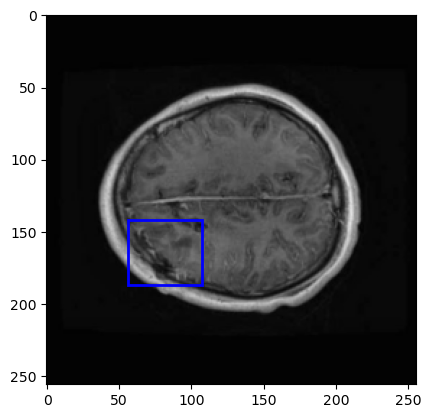

In [13]:
plt.imshow(img.permute(1, 2, 0).numpy(), cmap="gray")
rect = Rectangle(
        (b[0] - b[2]/2, b[1] - b[3]/2), b[2], b[3], linewidth=2, edgecolor="b", facecolor="none"
    )
plt.gca().add_patch(rect)

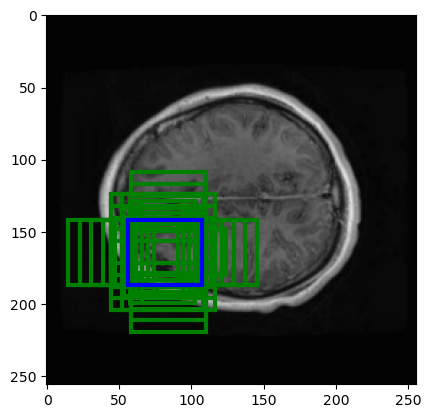

In [14]:
from matplotlib.patches import Rectangle


plt.imshow(img.permute(1, 2, 0).numpy(), cmap="gray")
for i in range(len(a_cen_p)):
    a = a_cen_p[i]

    rect = Rectangle(
            (a[0] - a[2]/2, a[1] - a[3]/2), a[2], a[3], linewidth=3, edgecolor="g", facecolor="none"
        )
    plt.gca().add_patch(rect)

rect = Rectangle(
            (b[0] - b[2]/2, b[1] - b[3]/2), b[2], b[3], linewidth=3, edgecolor="b", facecolor="none"
        )
plt.gca().add_patch(rect)

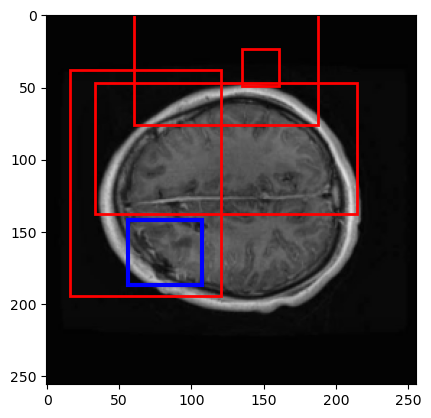

In [15]:
from matplotlib.patches import Rectangle
import random

plt.imshow(img.permute(1, 2, 0).numpy(), cmap="gray")
for i in range(len(a_cen_n)):
    if random.random() < 0.0005:
        a = a_cen_n[i]

        rect = Rectangle(
                (a[0] - a[2]/2, a[1] - a[3]/2), a[2], a[3], linewidth=2, edgecolor="r", facecolor="none"
            )
        plt.gca().add_patch(rect)

rect = Rectangle(
            (b[0] - b[2]/2, b[1] - b[3]/2), b[2], b[3], linewidth=3, edgecolor="b", facecolor="none"
        )
plt.gca().add_patch(rect)